In [2]:
# Import packages
import re
import os
import string
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

# Analytics/Metrics
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer


## TWEEPY STUFF
# Twitter Authentication
from src import ACCESS_TOKEN, ACCESS_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET
# Twitter Scraping Class
from src import TwitterClient
# Class for cleanup
from src import TweetAnalyzer
# NLP and Metrics

# Visualization


## Project Methodology

- [User Input] - Input query terms
- [Tweet Scraping] - Execute query on one term at a time (username or string) <- NOT DOING STRING YET
- [Tweet Cleaning] - Clean tweets and format into dataframe
- [Tweet Engineering] - Combine dataframes for all query terms in a subject area
- [NLP and Metrics] - Compute metrics and transformations
- [Visualize]

## Query Terms

In [ ]:
SUBJECT = "Space"

## Tweet Scraping

In [ ]:
# Input a screen name and see their recent tweets
USER = 'NASA'
Number_of_Tweets = 2

# Config params
twitter_client = TwitterClient(twitter_user=USER)

# Print if you wish
#print(twitter_client.get_user_timeline_tweets(Number_of_Tweets))

# Retrieve tweets
tweets = twitter_client.get_user_timeline_tweets(Number_of_Tweets)
# Format tweets into DF
df = TweetAnalyzer.tweets_to_data_frame(tweets)

In [ ]:
# Input a list of query terms and GET tweets
QUERY = ['NASA', 'space station', 'hubble']
Number_of_Tweets = 2

# Config params
twitter_client = TwitterClient(query_term=QUERY)

# Print if you wish
#print(twitter_client.get_query_tweets(Number_of_Tweets))

# Retrieve tweets
tweets = twitter_client.get_query_tweets(Number_of_Tweets)
# Format tweets into DF
df = TweetAnalyzer.tweets_to_data_frame(tweets)

## Tweet Cleaning

Steps:
- Remove extra columns
- Remove unnecessary characters
- Remove HTML tags, hyperlinks

In [ ]:
# Columns needed:
    # id, tweet, Screen Name, date, source, likes, retweets

#df = tweet_analyzer.tweets_to_data_frame(tweets)

In [3]:
stopwords = ['ourselves', 'here', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 
                'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 
                'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 
                'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 
                'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 
                'them', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 
                'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 
                'myself', 'which', 'those', 'i', 'I','after', 'few', 'whom', 'being', 'if', 'theirs', 'my', 'against','a', 'by', 'doing', 
                'it', 'how', 'further', 'was', 'here','than','can', 'let', 'll', 'the', 'to', 'and', 'in', 'we', 'you ', 'of', 'on', 'this',
                'be', 'our', 'or', 'it', 'we', 're']

In [5]:
## FUNCTIONS
def clean_special_chars(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def extract_hashtags(tweet):
    regex = "#(\w+)"
    hashtag_list = re.findall(regex, tweet)
    return hashtag_list

def extract_mentions(tweet):
    regex = "@(\w+)"
    mentions_list = re.findall(regex, tweet)
    return mentions_list

def count_caption_words(tweet):
    return sum([i.strip(string.punctuation).isalpha() for i in tweet.split()])

def remove_stopwords(tweet, stopwords):
    #tweet = [x.lower() for x in tweet]
    tweet = [word for word in tweet if word not in stopwords]
    return tweet

In [6]:
df = pd.read_csv("C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\Twitter News\\sample tweets\\tweets.csv")

In [7]:
# Extract pieces out of tweets and put into df columns
df['hashtags'] = df['tweet'].apply(extract_hashtags)
df['mentions'] = df['tweet'].apply(extract_mentions)

# Clean special characters from tweet text
df['tweet'] = df['tweet'].apply(clean_special_chars)

# Remove stop words
## NOT NEEDED AT THIS TIME
#df['tweet_nostops'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

# Compute length of each tweet (exclude really short ones)
df['tweet_length'] = df['tweet'].apply(count_caption_words)

In [8]:
# Not sure to keep?
# Remove short tweets.  Require that tweet is minimum of 5 words long.
df = df[df['tweet_length']>5]

In [9]:
df.head(10)

,id,tweet,date,source,likes,retweets,hashtags,mentions,tweet_length
0,1620202199019130880,Do you MealPrep What d be on the menu if you w...,2023-01-30 23:28:00+00:00,Sprinklr,2500,201,[MealPrep],[],23
1,1620190353604190210,On Tuesday Jan 31 Demo 2 astronauts Douglas Hu...,2023-01-30 22:40:56+00:00,Sprinklr,6268,533,[],[],16
2,1620172363726999555,Great question Our Milky Way galaxy will likel...,2023-01-30 21:29:27+00:00,Twitter Web App,51,7,[],[lwzc7799],16
4,1620158867958108161,You re looking at what may be hundreds or even...,2023-01-30 20:35:49+00:00,Sprinklr,8422,1124,[],[ChandraXRay],17
5,1620134198492401665,Great question A Sample Return Lander would la...,2023-01-30 18:57:48+00:00,Twitter Web App,6,2,[],"[TonyRoma1992, ExploreCosmos_, esa]",15
6,1620116242953822208,RT Someone understood the assignment It s offi...,2023-01-30 17:46:27+00:00,Twitter Web App,0,405,[MarsSampleReturn],"[NASAJPL, NASAPersevere]",17
7,1620098547835367427,The poem set to fly in space aboard and how yo...,2023-01-30 16:36:08+00:00,Twitter Web App,1002,116,[],"[librarycongress, adalimon, EuropaClipper, Eur...",13
8,1620096711875088384,A collaboration written in the stars We ve tea...,2023-01-30 16:28:50+00:00,Sprinklr,2794,363,[],"[LibraryCongress, AdaLimon]",17
9,1619779987204149249,We re sending a new crew to the Station NASA s...,2023-01-29 19:30:17+00:00,Sprinklr,10048,1042,[Crew6],"[Space_Station, SpaceX]",17
10,1619374684826664960,Good idea to take care of it before it gets ev...,2023-01-28 16:39:46+00:00,Twitter for iPhone,33,3,[],[eternallife2112],13


## Tweet Engineering

In [ ]:
# Combine datasets for a subject area

## NLP and Metrics

Steps:

- Topic Modeling (BERTopic)

- Analyze Sentiment for each tweet
- Count # of tweets in subject [GLOBAL]
- Count # of tweets in topic [Local]
- CountWordFrequency across subject
- Log accounts (most frequent mentions or other?)


In [10]:
# Prepare embeddings
docs = df['tweet'].tolist()
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=2)

topic_model = BERTopic(nr_topics = 3, #max number of topics
                       language = 'english',
                       vectorizer_model = vectorizer_model,
                       calculate_probabilities = True,
                       verbose=True)

topics, probabilities = topic_model.fit_transform(docs, embeddings)

c:\ProgramData\Miniconda3\envs\nlp_testing\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# Topic -1 is the catch-all bin for outliers.
# Need to modify min_df.  Believe this is the minimum number of obs to create a topic.
# From word frequency, believe ngram = 2 is good.
# ACTION: Generate more tweets and test with different min_df value.

topic_model.get_topic_freq().head()

,Topic,Count
0,-1,19


In [ ]:
# Sentiment analysis
#df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

# Count total len of df
total_tweets_in_subject = len(df)
print(total_tweets_in_subject)

# Count len of df where topic == some value
total_tweets_in_topic = []


Text(0.5, 1.0, 'Most Common Words from this Subject')

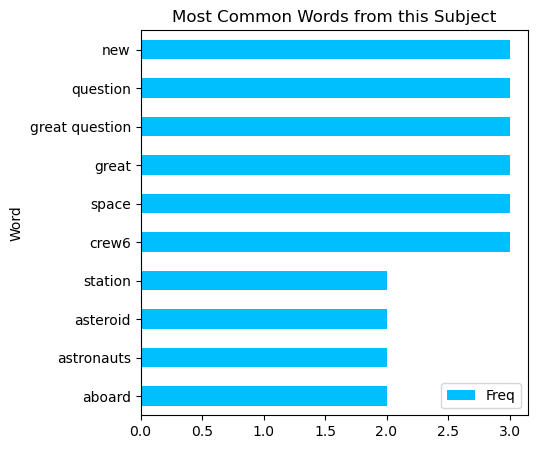

In [27]:
# CountWordFrequency

#Create DTM
cv = CountVectorizer(ngram_range = (1,3), stop_words='english')
dtm = cv.fit_transform(df['tweet'])
words = np.array(cv.get_feature_names())

#Look at top 15 most frequent words
freqs=dtm.sum(axis=0).A.flatten() 
index=np.argsort(freqs)[-10:]

# Construct dataframe
WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index]))) 
WordFreq.columns = ['Word', 'Freq']

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(5, 5))
WordFreq.sort_values(by='Freq').plot.barh(
                      x='Word',
                      y='Freq',
                      ax=ax,
                      color="deepskyblue")

plt.title("Most Common Words from this Subject")

In [ ]:
vectorizer = CountVectorizer(analyzer=lambda x: x)
dtm = vectorizer.fit_transform(df['mentions']).toarray()
mention = np.array(vectorizer.get_feature_names())


#Look at top 5 most frequent mentions
freqs=dtm.sum(axis=0).flatten()
index=np.argsort(freqs)[-5:] 

# Construct dataframe
Mentions = pd.DataFrame.from_records(list(zip(mention[index], freqs[index]))) 
Mentions.columns = ['Mention', 'Frequency']

Mentions.sort_values(by='Frequency', ascending=False, inplace=True)
Mentions.reset_index(inplace=True, drop=True)
Mentions

## Output Dataset

In [ ]:
# Create name of file

dirname = "C:\\Users\\t_zim\\Desktop\\Data\\Twitter\\"

# Just creates the string with {path} and {filename} ready to go
OUT_FILE = os.path.join(dirname, "{timestamp}_{subject}tweets.csv".format(timestamp=date.today(), subject=SUBJECT))
print(OUT_FILE)

In [ ]:
df.to_csv(OUT_FILE, index=False)